In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sklearn

In [2]:
# Read in the file and look at the first five rows
colorado = pd.read_table('CO_cleaned.csv',sep=',')
print(colorado.shape)
colorado.head()

/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2584744, 26)


,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,...,search_conducted,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,officer_id,officer_gender,vehicle_type,out_of_state
0,CO-2010-000001,CO,2010-01-01,00:00,10.0,Arapahoe County,8005.0,289,Golden,F,...,False,NaN,NaN,False,Verbal Warning,False,1024976.0,M,NA NA 0,False
1,CO-2010-000002,CO,2010-01-01,00:01,4.0,El Paso County,8041.0,3,Colorado Springs,F,...,False,NaN,NaN,False,Verbal Warning,False,1069803.0,NaN,NA NA 0,False
2,CO-2010-000003,CO,2010-01-01,00:01,24.0,Garfield County,8045.0,3,Glenwood Springs,M,...,False,NaN,NaN,False,Verbal Warning,False,1198321.0,M,NA NA 0,False
3,CO-2010-000004,CO,2010-01-01,00:02,19.0,Yuma County,8125.0,NaN,Sterling,M,...,False,NaN,NaN,False,Citation,False,1167059.0,NaN,Ford F-250 2003,False
4,CO-2010-000005,CO,2010-01-01,00:02,11.0,Jefferson County,8059.0,NaN,6A,F,...,False,NaN,NaN,False,Written Warning,False,1300790.0,NaN,Oldsmobile Intrigue 1999,False


**id** - The unique ID we assign to each stop. Contains the state and year.

**state** - The two-letter code for the state in which the stop occurred

**stop_date** - The date of the stop, in YYYY-MM-DD format. Some states do not provide the exact stop date: for example, they only provide the year or quarter in which the stop occurred. For these states, stop_date is set to the date at the beginning of the period: for example, January 1 if only year is provided.

**stop_time** - The 24-hour time of the stop, in HH:MM format.

**location_raw** - The original data value from which we compute the county (or comparably granular location) in which the stop occurred. Not in a standardized format across states.

**county_name** - The standardized name of the county in which the stop occurred.

**county_fips** - The standardized 5-digit FIPS code in which the stop occurred.

**district** - In several states (e.g., Illinois) the stop county cannot be inferred, but a comparably granular location can. This comparably granular location is stored in the district column. Most states do not have this column.

**fine_grained_location** - Any higher-resolution data about where the stop occurred: e.g., milepost or address. Not standardized across states.

**police_department** - The police department or agency that made the stop. Not in a standard format across states.

**driver_gender** - The driver’s gender, as recorded by the trooper. M, F, or NA.

**driver_age_raw** - The original data value from which we compute the driver’s age when they were stopped. May be age, birth year, or birth date. Not in a standard format across states.

**driver_age** - The driver’s age when they were stopped. Set to NA if less than 15 or greater than or equal to 100.

**driver_race_raw** - The original data value from which the driver’s standardized race is computed. Not in a standard format across states.

**driver_race** - The standardized driver race. Possible values are White, Black, Hispanic, Asian, Other, and NA, with NA denoting values which are unknown. Asian refers to Asian, Pacific Islander, and Indian. Native Americans/American Indians are included in the "other" category. Anyone with Hispanic ethnicity is classified as Hispanic, regardless of their recorded race.

**violation_raw** - The violation committed by the driver, in the language of the original data. Not in a standard format across states. Some stops have multiple violations.

**violation** - The violation committed by the driver, standardized into categories that are consistent across states.

**search_conducted** - A TRUE/FALSE value indicating whether a search was performed.

**search_type_raw** - The justification for the search, in the language of the original data. NA if no search was performed. Not in a standard format across states. Some states have multiple justifications for a search. 

**search_type** - The normalized justification for the search. Where possible, this is standardized into categories which are consistent across states. For example, if something is clearly a consent search, search_type is referred to as “Consent”. 

**contraband_found** - A TRUE/FALSE value indicating whether a search was performed and contraband was found. FALSE if no search was performed. 

**stop_outcome** - The outcome of the stop. Many states have idiosyncratic outcomes — for example, “CHP 215” in California — so this column is not standardized across states. “Citation” and “Warning” are the values which occur most commonly across states. If the stop has multiple outcomes, the most severe outcome is used. For example, if a stop resulted in a citation and a warning, stop_outcome would be “Citation”. 

**is_arrested** - A TRUE/FALSE value indicating whether an arrest was made.

**officer_id**

**officer_gender**

**vehicle_type**

**out_of_state**

*For several fields (e.g., driver_race) we include a "raw" column which records the original data values from which we infer standardized values. For example, driver_race_raw might be “White Hispanic” which we code as “Hispanic” in the standardized driver_race field. We include the raw columns because our data processing pipeline is extensive, requiring judgment calls and subjective decisions. We aim to make our data processing as transparent as possible. Other analysts may choose to process the raw data differently if their needs or judgments differ.* (https://github.com/5harad/openpolicing/blob/master/DATA-README.md)

In [3]:
# Drop the raw columns and duplicative columns.
colorado.drop(['state','location_raw','driver_age_raw','driver_race_raw','violation_raw','search_type_raw',
               'county_fips','fine_grained_location'],axis=1, inplace = True)
# Drop columns we decided we did not need from exploratory analysis (vehicle_type and search_type are mostly null,
#stop_outcome and officer_gender are about half null, officer_id is mostly unique), and columns we do not need for 
#the model.
colorado.drop(['vehicle_type','search_type','stop_outcome','officer_gender','id','stop_date','stop_time','officer_id'],
              axis=1,inplace = True)
print(colorado.shape)

(2584744, 10)


In [4]:
# Change column from boolean to string
colorado[['search_conducted']] = colorado[['search_conducted']].astype(str)

In [5]:
# Type of value for each column
colorado.dtypes

county_name           object
police_department     object
driver_gender         object
driver_age           float64
driver_race           object
violation             object
search_conducted      object
contraband_found      object
is_arrested           object
out_of_state          object
dtype: object

In [6]:
# Count the number of null values in each column. In total there are 2,584,744 rows.
colorado.isnull().sum()

county_name              27
police_department      4688
driver_gender        368416
driver_age           396639
driver_race          399256
violation            458176
search_conducted          0
contraband_found         41
is_arrested          899913
out_of_state           1180
dtype: int64

The null values will be turned into a separate category in the remaining columns. The column is_arrested has 899913 null values, which is very high. We may try removing that feature later.

In [7]:
colorado.county_name.replace(np.NaN, 'unknown', inplace=True)
colorado.police_department.replace(np.NaN, 'unknown', inplace=True)
colorado.driver_gender.replace(np.NaN, 'unknown', inplace=True)
colorado.driver_age.replace(np.NaN, 'unknown', inplace=True)
colorado.driver_race.replace(np.NaN, 'unknown', inplace=True)
colorado.violation.replace(np.NaN, 'unknown', inplace=True)
colorado.contraband_found.replace(np.NaN, 'unknown', inplace=True)
colorado.is_arrested.replace(np.NaN, 'unknown', inplace=True)
colorado.out_of_state.replace(np.NaN, 'unknown', inplace=True)
colorado.isnull().sum()

county_name          0
police_department    0
driver_gender        0
driver_age           0
driver_race          0
violation            0
search_conducted     0
contraband_found     0
is_arrested          0
out_of_state         0
dtype: int64

In [8]:
colorado.head()

,county_name,police_department,driver_gender,driver_age,driver_race,violation,search_conducted,contraband_found,is_arrested,out_of_state
0,Arapahoe County,Golden,F,19,White,Lights,False,False,False,False
1,El Paso County,Colorado Springs,F,16,White,Speeding,False,False,False,False
2,Garfield County,Glenwood Springs,M,60,White,Safe movement,False,False,False,False
3,Yuma County,Sterling,M,30,White,License,False,False,False,False
4,Jefferson County,6A,F,19,Hispanic,Lights,False,False,False,False


In [9]:
# Count the number of unique values in each column
colorado.apply(lambda x: len(x.unique()))

county_name            65
police_department      54
driver_gender           3
driver_age             86
driver_race             6
violation            1953
search_conducted        2
contraband_found        3
is_arrested             3
out_of_state            3
dtype: int64

All columns are categorical, and categorical columns need to be in 0/1 format: search_conducted (True/False).

Categorical columns with more than one category need to be flattened out so they can also have 0/1 format: county_name, police_department, driver_gender, driver_age, driver_race, and violation. driver_gender, contraband_found, is_arrested, and out_of_state have an unknown column, so they are treated as multi-class.

In [10]:
# Change categorical to 0 and 1 instead of False/True.
colorado.search_conducted.replace(('True', 'False'), (1, 0), inplace=True)
colorado.head()

,county_name,police_department,driver_gender,driver_age,driver_race,violation,search_conducted,contraband_found,is_arrested,out_of_state
0,Arapahoe County,Golden,F,19,White,Lights,0,False,False,False
1,El Paso County,Colorado Springs,F,16,White,Speeding,0,False,False,False
2,Garfield County,Glenwood Springs,M,60,White,Safe movement,0,False,False,False
3,Yuma County,Sterling,M,30,White,License,0,False,False,False
4,Jefferson County,6A,F,19,Hispanic,Lights,0,False,False,False


In [11]:
# Before flattening the multi-category columns, we want to create another dataset with the top 80% of violations
coloradoClusterSmall = colorado[(colorado.violation == 'Speeding') |
                               (colorado.violation == 'Safe movement') |
                               (colorado.violation == 'Other') |
                               (colorado.violation == 'Lights') |
                               (colorado.violation == 'Registration/plates') |
                               (colorado.violation == 'Other (non-mapped)') |
                               (colorado.violation == 'Truck') |
                               (colorado.violation == 'Paperwork,Speeding') |
                               (colorado.violation == 'Equipment') |
                               (colorado.violation == 'License,Speeding') |
                               (colorado.violation == 'Seat belt,Speeding')]
coloradoClusterSmall.shape

(1709208, 10)

In [12]:
# Make multi-category columns separate columns of 0 and 1 for dataset with 80% (top 11) of violations.
#coloradoClusterSmall = pd.get_dummies(coloradoClusterSmall,columns=['county_name', 'police_department', 'driver_gender',
#                                                        'driver_age', 'driver_race', 'violation','contraband_found',
#                                                        'is_arrested','out_of_state'])
#coloradoClusterSmall.shape

In [13]:
# The K optimizer was not running with original "Small" dataset, so we will subset to features present "before" the 
#stop. We also will remove police_dept because it is somewhat duplicative to county_name, and a driver would not be
#able to control that piece.
coloradoClusterSmall.drop(['police_department','search_conducted','contraband_found','is_arrested'], axis=1, inplace = True)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [14]:
# Make multi-category columns separate columns of 0 and 1 for dataset with 80% (top 11) of violations, and only 
#"before" stop features.
coloradoClusterSmall = pd.get_dummies(coloradoClusterSmall,columns=['county_name','driver_gender','driver_age',
                                                                    'driver_race','violation','out_of_state'])
coloradoClusterSmall.shape

(1709208, 174)

## Cluster Model

### Figure Out the Number of Clusters to Use With the Elbow Method - Small Dataset

In [15]:
#Columns representing the offers, i.e. - the 0/1 columns
x_cols = coloradoClusterSmall.columns[1:]
X = coloradoClusterSmall[x_cols]
Xar = X.as_matrix()

In [16]:
K = range(2,8)
cluster_errors = []

for k in K:
  clusters = KMeans(n_clusters=k)
  clusters.fit(X)
  cluster_errors.append(clusters.inertia_)

In [17]:
#Create a dataframe with the number of clusters and the "cluster error"
clusters_df = pd.DataFrame({"num_clusters":K, "cluster_errors":cluster_errors})
clusters_df[:]

,cluster_errors,num_clusters
0,5.903424e+06,2
1,5.328447e+06,3
2,4.942003e+06,4
3,4.692761e+06,5
4,4.598746e+06,6
5,4.466521e+06,7


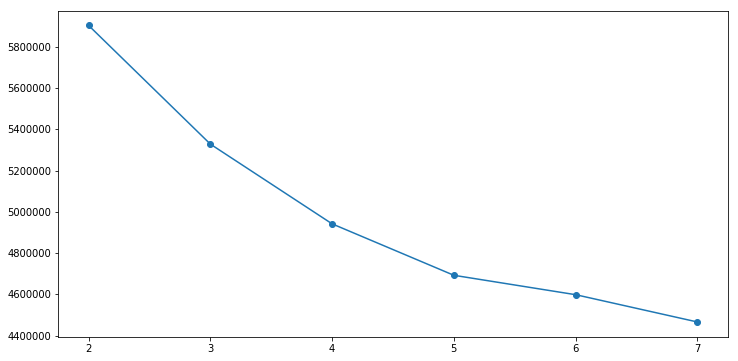

In [18]:
plt.figure(figsize=(12,6))
plt.plot(clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o")
plt.show()

In [19]:
#There is a general curve down, but I will choose 5. The drop from five to six is fairly minimal.
cluster = KMeans(n_clusters=5)
#Use only 0/1 columns
coloradoClusterSmall['cluster'] = cluster.fit_predict(X)
coloradoClusterSmall.cluster.value_counts()

3    513971
1    461478
0    388161
4    232652
2    112946
Name: cluster, dtype: int64

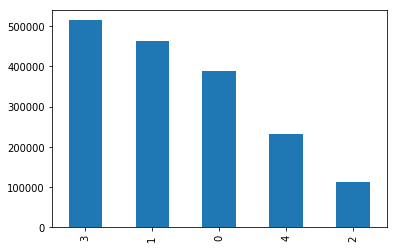

In [20]:
# Plot showing the number of stops in each cluster
s = coloradoClusterSmall.cluster.value_counts()
s.plot.bar()
plt.show()

## Visualize the Clusters using PCA

Principal Component Analysis (PCA) helps reduce the dimensionality of our data from 174 to something lower. To visualize on the coordinate plane, we reduce to 2 dimensions.

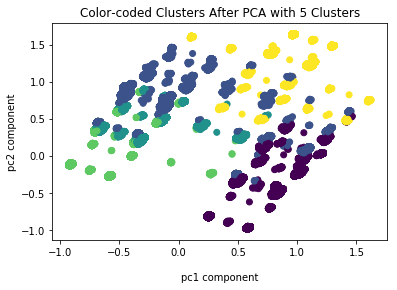

In [23]:
# Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
clusterer = KMeans(n_clusters=5, random_state=10)
cluster_labels = clusterer.fit_predict(X)
    
# Create a PCA model with 2 components: pca
pca = sklearn.decomposition.PCA(n_components=2)
    
# Fit and Transform the PCA instance to the data
pc1, pc2 = zip(*pca.fit_transform(X))
    
# build the scatterplot such that each (pc1, pc2) point is colored according to the color in the color map, whose
# index is in c=cluster_labels_list
cluster_labels_list = cluster_labels.tolist()
plt.scatter(pc1, pc2, c=cluster_labels)
    
# label axes
plt.xlabel('\npc1 component')
plt.ylabel('pc2 component')
    
# add title
plt.title("Color-coded Clusters After PCA with 5 Clusters")
    
# show plot
plt.show()

## Collapse the Dataframe back down

In [24]:
coloradoClusterSmall.head(10)

,county_name_Adams County,county_name_Alamosa County,county_name_Arapahoe County,county_name_Archuleta County,county_name_Baca County,county_name_Bent County,county_name_Boulder County,county_name_Broomfield County,county_name_Chaffee County,county_name_Cheyenne County,...,"violation_Paperwork,Speeding",violation_Registration/plates,violation_Safe movement,"violation_Seat belt,Speeding",violation_Speeding,violation_Truck,out_of_state_False,out_of_state_True,out_of_state_unknown,cluster
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,3
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,3
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,3
10,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,3
11,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,3
12,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,4
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [25]:
coloradoClusterSmall.tail(10)

,county_name_Adams County,county_name_Alamosa County,county_name_Arapahoe County,county_name_Archuleta County,county_name_Baca County,county_name_Bent County,county_name_Boulder County,county_name_Broomfield County,county_name_Chaffee County,county_name_Cheyenne County,...,"violation_Paperwork,Speeding",violation_Registration/plates,violation_Safe movement,"violation_Seat belt,Speeding",violation_Speeding,violation_Truck,out_of_state_False,out_of_state_True,out_of_state_unknown,cluster
2584722,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2584723,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,3
2584725,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
2584727,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,3
2584731,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
2584734,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
2584735,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2584736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2584737,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
2584739,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [26]:
# Reset the index
coloradoClusterSmall = coloradoClusterSmall.reset_index(drop=True)

In [27]:
coloradoClusterSmall.tail(10)

,county_name_Adams County,county_name_Alamosa County,county_name_Arapahoe County,county_name_Archuleta County,county_name_Baca County,county_name_Bent County,county_name_Boulder County,county_name_Broomfield County,county_name_Chaffee County,county_name_Cheyenne County,...,"violation_Paperwork,Speeding",violation_Registration/plates,violation_Safe movement,"violation_Seat belt,Speeding",violation_Speeding,violation_Truck,out_of_state_False,out_of_state_True,out_of_state_unknown,cluster
1709198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1709199,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,3
1709200,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
1709201,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,3
1709202,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
1709203,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
1709204,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1709205,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1709206,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
1709207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [28]:
list(coloradoClusterSmall)

['county_name_Adams County',
 'county_name_Alamosa County',
 'county_name_Arapahoe County',
 'county_name_Archuleta County',
 'county_name_Baca County',
 'county_name_Bent County',
 'county_name_Boulder County',
 'county_name_Broomfield County',
 'county_name_Chaffee County',
 'county_name_Cheyenne County',
 'county_name_Clear Creek County',
 'county_name_Conejos County',
 'county_name_Costilla County',
 'county_name_Crowley County',
 'county_name_Custer County',
 'county_name_Delta County',
 'county_name_Denver County',
 'county_name_Dolores County',
 'county_name_Douglas County',
 'county_name_Eagle County',
 'county_name_El Paso County',
 'county_name_Elbert County',
 'county_name_Fremont County',
 'county_name_Garfield County',
 'county_name_Gilpin County',
 'county_name_Grand County',
 'county_name_Gunnison County',
 'county_name_Hinsdale County',
 'county_name_Huerfano County',
 'county_name_Jackson County',
 'county_name_Jefferson County',
 'county_name_Kiowa County',
 'county_n

In [29]:
county = coloradoClusterSmall.loc[:, :'county_name_unknown']
gender = coloradoClusterSmall.loc[:, 'driver_gender_F':'driver_gender_unknown']
age = coloradoClusterSmall.loc[:, 'driver_age_15.0':'driver_age_unknown']
race = coloradoClusterSmall.loc[:, 'driver_race_Asian':'driver_race_unknown']
violation = coloradoClusterSmall.loc[:, 'violation_Equipment':'violation_Truck']
state = coloradoClusterSmall.loc[:, 'out_of_state_False':'out_of_state_unknown']
cluster = coloradoClusterSmall['cluster']

In [30]:
county2 = pd.Series(county.columns[np.where(county!=0)[1]])
gender2 = pd.Series(gender.columns[np.where(gender!=0)[1]])
age2 = pd.Series(age.columns[np.where(age!=0)[1]])
race2 = pd.Series(race.columns[np.where(race!=0)[1]])
violation2 = pd.Series(violation.columns[np.where(violation!=0)[1]])
state2 = pd.Series(state.columns[np.where(state!=0)[1]])

In [31]:
print(county2.shape)
print(gender2.shape)
print(age2.shape)
print(race2.shape)
print(violation2.shape)
print(state2.shape)
print(cluster.shape)

(1709208,)
(1709208,)
(1709208,)
(1709208,)
(1709208,)
(1709208,)
(1709208,)


In [32]:
coClusterNew = pd.DataFrame({'county': county2, 'gender': gender2, 'age':age2, 'race':race2, 'violation':violation2,
                            'out_of_state':state2,'cluster':cluster})
coClusterNew.shape

(1709208, 7)

In [33]:
#Subset the dataframe by cluster group to analyze
cluster0 = coClusterNew[coClusterNew['cluster']==0]
cluster1 = coClusterNew[coClusterNew['cluster']==1]
cluster2 = coClusterNew[coClusterNew['cluster']==2]
cluster3 = coClusterNew[coClusterNew['cluster']==3]
cluster4 = coClusterNew[coClusterNew['cluster']==4]

In [34]:
cluster0.head()
print(cluster0.shape)
print(cluster1.shape)
print(cluster2.shape)
print(cluster3.shape)
print(cluster4.shape)

(388161, 7)
(461478, 7)
(112946, 7)
(513971, 7)
(232652, 7)


## Cluster0

In [35]:
# Count the number of null values in each column.
cluster0.isnull().sum()

age             0
cluster         0
county          0
gender          0
out_of_state    0
race            0
violation       0
dtype: int64

In [36]:
# Count stops by age of driver
cluster0age = cluster0['age'].value_counts().sort_values(ascending=False).head(50)
cluster0age = cluster0age.to_frame()
cluster0age.columns = ['count']
cluster0age['driver_age'] = cluster0age.index
cluster0age['percent'] = cluster0age['count']/(cluster0['age'].notnull().sum())
cluster0age.head(12)

,count,driver_age,percent
driver_age_19.0,9941,driver_age_19.0,0.025611
driver_age_20.0,9603,driver_age_20.0,0.024740
driver_age_21.0,9385,driver_age_21.0,0.024178
driver_age_23.0,9322,driver_age_23.0,0.024016
driver_age_24.0,9319,driver_age_24.0,0.024008
driver_age_22.0,9296,driver_age_22.0,0.023949
driver_age_29.0,9296,driver_age_29.0,0.023949
driver_age_28.0,9271,driver_age_28.0,0.023884
driver_age_25.0,9249,driver_age_25.0,0.023828
driver_age_26.0,9212,driver_age_26.0,0.023732


Current size: [16.0, 12.0]


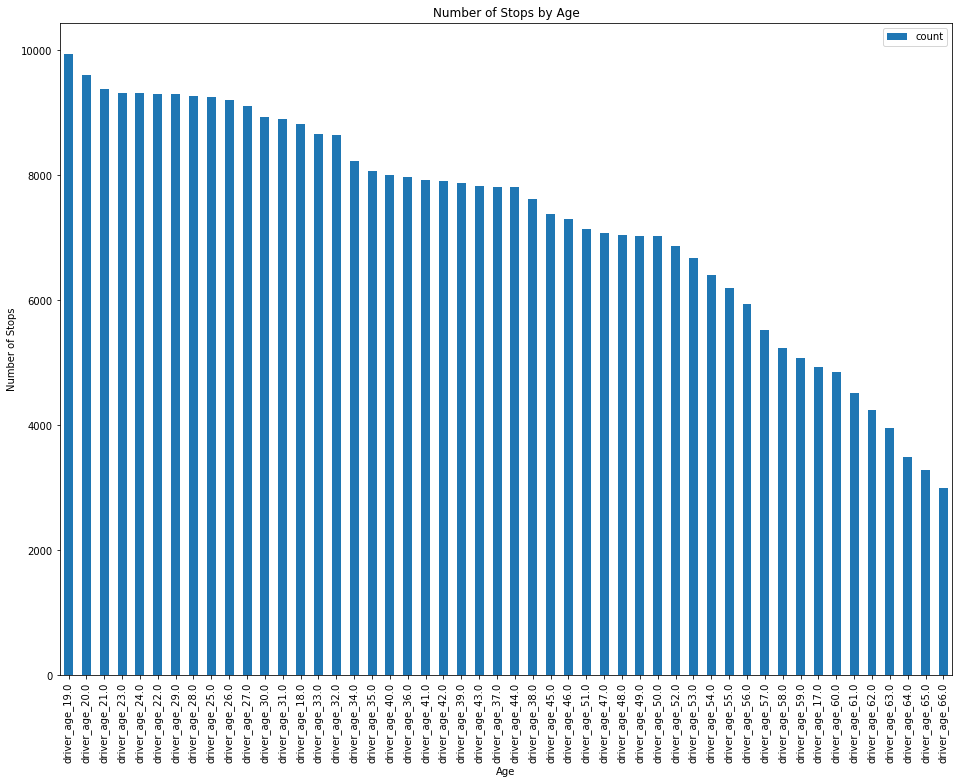

In [38]:
#Show Top 50 Ages of Drivers Pulled Over
cluster0age.plot.bar(x='driver_age', y='count')
plt.xlabel('Age')
plt.ylabel('Number of Stops')
plt.title('Number of Stops by Age')

# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [16.0, 12.0]
print "Current size:", fig_size

# Set figure width to 16 and height to 12
fig_size[0] = 16
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

plt.show()

In [39]:
# Count stops by gender of driver
cluster0gender = cluster0['gender'].value_counts().sort_values(ascending=False)
cluster0gender = cluster0gender.to_frame()
cluster0gender.columns = ['count']
cluster0gender['driver_gender'] = cluster0gender.index
cluster0gender['percent'] = cluster0gender['count']/(cluster0['gender'].notnull().sum())
cluster0gender.head()

,count,driver_gender,percent
driver_gender_M,388017,driver_gender_M,0.999629
driver_gender_unknown,144,driver_gender_unknown,0.000371


In [40]:
# Count stops by race of driver
cluster0race = cluster0['race'].value_counts().sort_values(ascending=False)
cluster0race = cluster0race.to_frame()
cluster0race.columns = ['count']
cluster0race['driver_race'] = cluster0race.index
cluster0race['percent'] = cluster0race['count']/(cluster0['race'].notnull().sum())
cluster0race.head()

,count,driver_race,percent
driver_race_White,324460,driver_race_White,0.835890
driver_race_Hispanic,41318,driver_race_Hispanic,0.106446
driver_race_Black,11119,driver_race_Black,0.028645
driver_race_Asian,5944,driver_race_Asian,0.015313
driver_race_unknown,4960,driver_race_unknown,0.012778


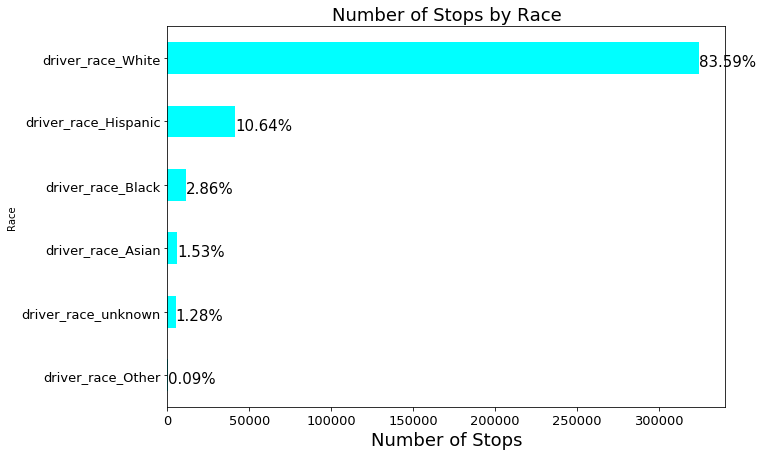

In [41]:
#Show Race of Drivers Pulled Over
ax = cluster0['race'].value_counts().plot(kind='barh', figsize=(10,7),
                                        color='aqua', fontsize=13);
ax.set_alpha(0.8)
ax.set_title('Number of Stops by Race', fontsize=18)
ax.set_xlabel('Number of Stops', fontsize=18)
ax.set_ylabel('Race')

# Add percentages to each bar
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='black')
    
# invert for largest on top 
ax.invert_yaxis()

plt.show()

In [42]:
# Count stops by county of driver
cluster0county = cluster0['county'].value_counts().sort_values(ascending=False)
cluster0county = cluster0county.to_frame()
cluster0county.columns = ['count']
cluster0county['county_name'] = cluster0county.index
cluster0county['percent'] = cluster0county['count']/(cluster0['county'].notnull().sum())
cluster0county.head()

,count,county_name,percent
county_name_El Paso County,30855,county_name_El Paso County,0.079490
county_name_Jefferson County,27967,county_name_Jefferson County,0.072050
county_name_Adams County,18468,county_name_Adams County,0.047578
county_name_Mesa County,18180,county_name_Mesa County,0.046836
county_name_Weld County,15227,county_name_Weld County,0.039229


In [43]:
# Count stops by driver violation
cluster0violation = cluster0['violation'].value_counts().sort_values(ascending=False).head()
cluster0violation = cluster0violation.to_frame()
cluster0violation.columns = ['count']
cluster0violation['violation'] = cluster0violation.index
cluster0violation['percent'] = cluster0violation['count']/(cluster0['violation'].notnull().sum())
cluster0violation.head()

,count,violation,percent
violation_Speeding,388161,violation_Speeding,1.0


In [44]:
# Count stops for In or Out of State 
cluster0state = cluster0['out_of_state'].value_counts().sort_values(ascending=False)
cluster0state = cluster0state.to_frame()
cluster0state.columns = ['count']
cluster0state['out_of_state'] = cluster0state.index
cluster0state['percent'] = cluster0state['count']/(cluster0['out_of_state'].notnull().sum())
cluster0state.head()

,count,out_of_state,percent
out_of_state_False,387959,out_of_state_False,0.99948
out_of_state_unknown,202,out_of_state_unknown,0.00052


## Cluster1

In [45]:
# Count stops by age of driver
cluster1age = cluster1['age'].value_counts().sort_values(ascending=False).head(50)
cluster1age = cluster1age.to_frame()
cluster1age.columns = ['count']
cluster1age['driver_age'] = cluster1age.index
cluster1age['percent'] = cluster1age['count']/(cluster1['age'].notnull().sum())
cluster1age.head(12)

,count,driver_age,percent
driver_age_19.0,11710,driver_age_19.0,0.025375
driver_age_20.0,11620,driver_age_20.0,0.025180
driver_age_22.0,11518,driver_age_22.0,0.024959
driver_age_21.0,11456,driver_age_21.0,0.024825
driver_age_24.0,11411,driver_age_24.0,0.024727
driver_age_23.0,11403,driver_age_23.0,0.024710
driver_age_25.0,11381,driver_age_25.0,0.024662
driver_age_18.0,11095,driver_age_18.0,0.024042
driver_age_26.0,10910,driver_age_26.0,0.023641
driver_age_28.0,10696,driver_age_28.0,0.023178


Current size: [16.0, 12.0]


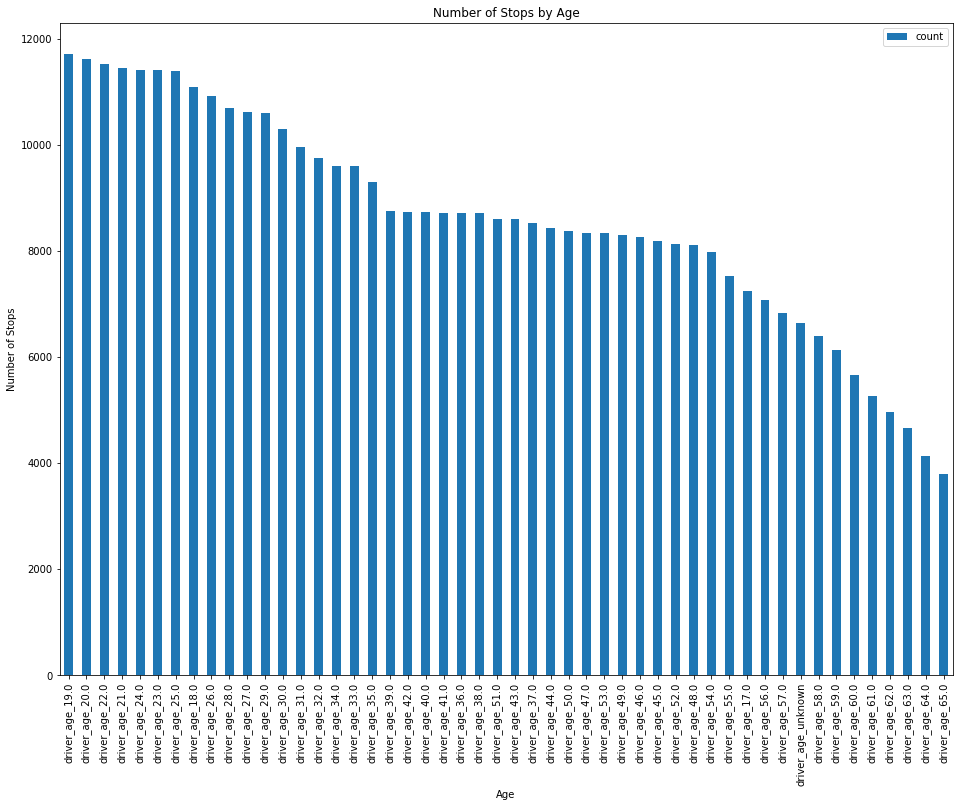

In [46]:
#Show Top 50 Ages of Drivers Pulled Over
cluster1age.plot.bar(x='driver_age', y='count')
plt.xlabel('Age')
plt.ylabel('Number of Stops')
plt.title('Number of Stops by Age')

# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [16.0, 12.0]
print "Current size:", fig_size

# Set figure width to 16 and height to 12
fig_size[0] = 16
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

plt.show()

In [47]:
# Count stops by gender of driver
cluster1gender = cluster1['gender'].value_counts().sort_values(ascending=False)
cluster1gender = cluster1gender.to_frame()
cluster1gender.columns = ['count']
cluster1gender['driver_gender'] = cluster1gender.index
cluster1gender['percent'] = cluster1gender['count']/(cluster1['gender'].notnull().sum())
cluster1gender.head()

,count,driver_gender,percent
driver_gender_M,460164,driver_gender_M,0.997153
driver_gender_unknown,1314,driver_gender_unknown,0.002847


In [48]:
# Count stops by race of driver
cluster1race = cluster1['race'].value_counts().sort_values(ascending=False)
cluster1race = cluster1race.to_frame()
cluster1race.columns = ['count']
cluster1race['driver_race'] = cluster1race.index
cluster1race['percent'] = cluster1race['count']/(cluster1['race'].notnull().sum())
cluster1race.head()

,count,driver_race,percent
driver_race_White,362391,driver_race_White,0.785283
driver_race_Hispanic,70627,driver_race_Hispanic,0.153045
driver_race_Black,14638,driver_race_Black,0.031720
driver_race_Asian,6751,driver_race_Asian,0.014629
driver_race_unknown,6657,driver_race_unknown,0.014425


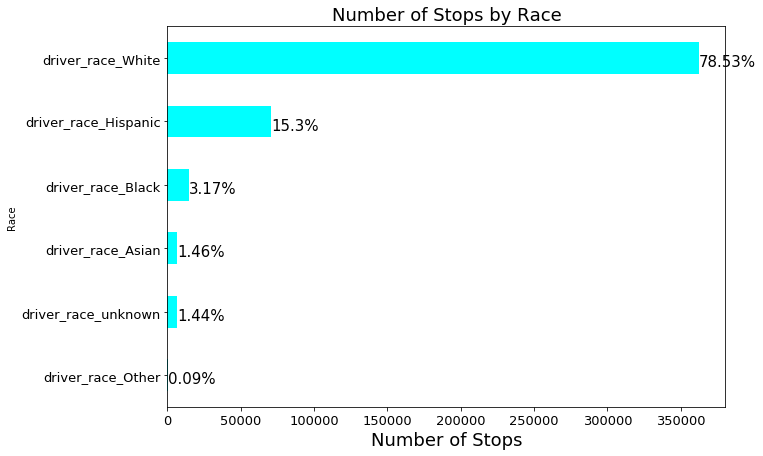

In [49]:
#Show Race of Drivers Pulled Over
ax = cluster1['race'].value_counts().plot(kind='barh', figsize=(10,7),
                                        color='aqua', fontsize=13);
ax.set_alpha(0.8)
ax.set_title('Number of Stops by Race', fontsize=18)
ax.set_xlabel('Number of Stops', fontsize=18)
ax.set_ylabel('Race')

# Add percentages to each bar
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='black')
    
# invert for largest on top 
ax.invert_yaxis()

plt.show()

In [50]:
# Count stops by county of driver
cluster1county = cluster1['county'].value_counts().sort_values(ascending=False)
cluster1county = cluster1county.to_frame()
cluster1county.columns = ['count']
cluster1county['county_name'] = cluster1county.index
cluster1county['percent'] = cluster1county['count']/(cluster1['county'].notnull().sum())
cluster1county.head()

,count,county_name,percent
county_name_Jefferson County,44639,county_name_Jefferson County,0.096731
county_name_El Paso County,41224,county_name_El Paso County,0.089330
county_name_Adams County,34713,county_name_Adams County,0.075221
county_name_Larimer County,23681,county_name_Larimer County,0.051316
county_name_Weld County,23188,county_name_Weld County,0.050247


In [51]:
# Count stops by driver violation
cluster1violation = cluster1['violation'].value_counts().sort_values(ascending=False).head()
cluster1violation = cluster1violation.to_frame()
cluster1violation.columns = ['count']
cluster1violation['violation'] = cluster1violation.index
cluster1violation['percent'] = cluster1violation['count']/(cluster1['violation'].notnull().sum())
cluster1violation.head()

,count,violation,percent
violation_Safe movement,145254,violation_Safe movement,0.314758
violation_Lights,77835,violation_Lights,0.168665
violation_Registration/plates,75754,violation_Registration/plates,0.164155
violation_Other (non-mapped),35612,violation_Other (non-mapped),0.077169
violation_Other,31102,violation_Other,0.067396


In [52]:
# Count stops for In or Out of State 
cluster1state = cluster1['out_of_state'].value_counts().sort_values(ascending=False)
cluster1state = cluster1state.to_frame()
cluster1state.columns = ['count']
cluster1state['out_of_state'] = cluster1state.index
cluster1state['percent'] = cluster1state['count']/(cluster1['out_of_state'].notnull().sum())
cluster1state.head()

,count,out_of_state,percent
out_of_state_False,461147,out_of_state_False,0.999283
out_of_state_unknown,331,out_of_state_unknown,0.000717


## Cluster2

In [53]:
# Count stops by age of driver
cluster2age = cluster2['age'].value_counts().sort_values(ascending=False).head(50)
cluster2age = cluster2age.to_frame()
cluster2age.columns = ['count']
cluster2age['driver_age'] = cluster2age.index
cluster2age['percent'] = cluster2age['count']/(cluster2['age'].notnull().sum())
cluster2age.head(12)

,count,driver_age,percent
driver_age_unknown,111112,driver_age_unknown,0.983762
driver_age_21.0,50,driver_age_21.0,0.000443
driver_age_19.0,49,driver_age_19.0,0.000434
driver_age_22.0,48,driver_age_22.0,0.000425
driver_age_53.0,47,driver_age_53.0,0.000416
driver_age_24.0,46,driver_age_24.0,0.000407
driver_age_18.0,46,driver_age_18.0,0.000407
driver_age_20.0,45,driver_age_20.0,0.000398
driver_age_46.0,45,driver_age_46.0,0.000398
driver_age_31.0,44,driver_age_31.0,0.000390


Current size: [16.0, 12.0]


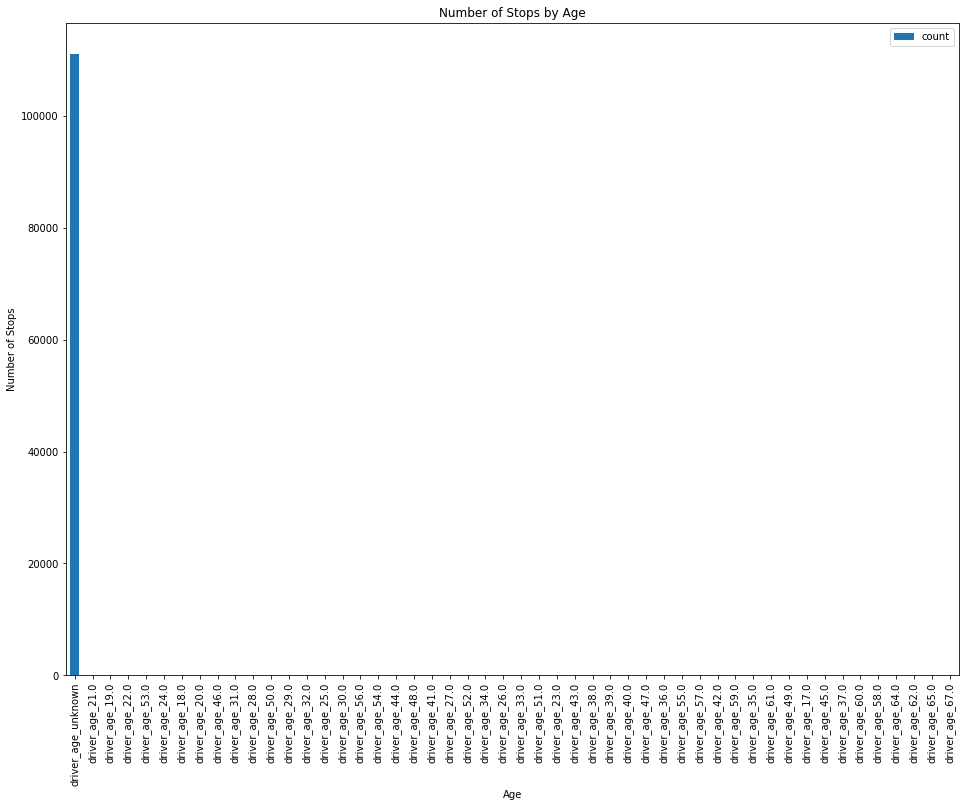

In [54]:
#Show Top 50 Ages of Drivers Pulled Over
cluster2age.plot.bar(x='driver_age', y='count')
plt.xlabel('Age')
plt.ylabel('Number of Stops')
plt.title('Number of Stops by Age')

# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [16.0, 12.0]
print "Current size:", fig_size

# Set figure width to 16 and height to 12
fig_size[0] = 16
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

plt.show()

In [55]:
# Count stops by gender of driver
cluster2gender = cluster2['gender'].value_counts().sort_values(ascending=False)
cluster2gender = cluster2gender.to_frame()
cluster2gender.columns = ['count']
cluster2gender['driver_gender'] = cluster2gender.index
cluster2gender['percent'] = cluster2gender['count']/(cluster2['gender'].notnull().sum())
cluster2gender.head()

,count,driver_gender,percent
driver_gender_unknown,111728,driver_gender_unknown,0.989216
driver_gender_M,756,driver_gender_M,0.006693
driver_gender_F,462,driver_gender_F,0.004090


In [56]:
# Count stops by race of driver
cluster2race = cluster2['race'].value_counts().sort_values(ascending=False)
cluster2race = cluster2race.to_frame()
cluster2race.columns = ['count']
cluster2race['driver_race'] = cluster2race.index
cluster2race['percent'] = cluster2race['count']/(cluster2['race'].notnull().sum())
cluster2race.head()

,count,driver_race,percent
driver_race_unknown,111372,driver_race_unknown,0.986064
driver_race_White,1262,driver_race_White,0.011173
driver_race_Hispanic,218,driver_race_Hispanic,0.001930
driver_race_Black,65,driver_race_Black,0.000575
driver_race_Asian,25,driver_race_Asian,0.000221


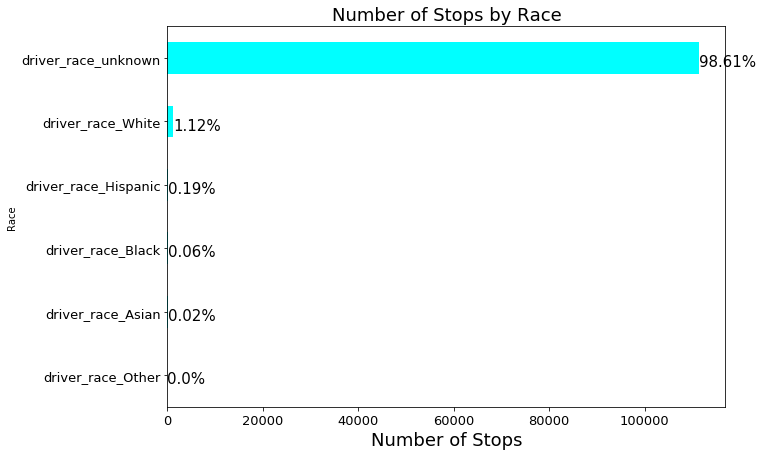

In [57]:
#Show Race of Drivers Pulled Over
ax = cluster2['race'].value_counts().plot(kind='barh', figsize=(10,7),
                                        color='aqua', fontsize=13);
ax.set_alpha(0.8)
ax.set_title('Number of Stops by Race', fontsize=18)
ax.set_xlabel('Number of Stops', fontsize=18)
ax.set_ylabel('Race')

# Add percentages to each bar
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='black')
    
# invert for largest on top 
ax.invert_yaxis()

plt.show()

In [58]:
# Count stops by county of driver
cluster2county = cluster2['county'].value_counts().sort_values(ascending=False)
cluster2county = cluster2county.to_frame()
cluster2county.columns = ['count']
cluster2county['county_name'] = cluster2county.index
cluster2county['percent'] = cluster2county['count']/(cluster2['county'].notnull().sum())
cluster2county.head()

,count,county_name,percent
county_name_El Paso County,13802,county_name_El Paso County,0.122200
county_name_Jefferson County,11195,county_name_Jefferson County,0.099118
county_name_Eagle County,7334,county_name_Eagle County,0.064934
county_name_Adams County,6387,county_name_Adams County,0.056549
county_name_Boulder County,5772,county_name_Boulder County,0.051104


In [59]:
# Count stops by driver violation
cluster2violation = cluster2['violation'].value_counts().sort_values(ascending=False).head()
cluster2violation = cluster2violation.to_frame()
cluster2violation.columns = ['count']
cluster2violation['violation'] = cluster2violation.index
cluster2violation['percent'] = cluster2violation['count']/(cluster2['violation'].notnull().sum())
cluster2violation.head()

,count,violation,percent
violation_Other,107468,violation_Other,0.951499
violation_Registration/plates,1868,violation_Registration/plates,0.016539
violation_Other (non-mapped),1637,violation_Other (non-mapped),0.014494
violation_Truck,686,violation_Truck,0.006074
violation_Safe movement,613,violation_Safe movement,0.005427


In [60]:
# Count stops for In or Out of State 
cluster2state = cluster2['out_of_state'].value_counts().sort_values(ascending=False)
cluster2state = cluster2state.to_frame()
cluster2state.columns = ['count']
cluster2state['out_of_state'] = cluster2state.index
cluster2state['percent'] = cluster2state['count']/(cluster2['out_of_state'].notnull().sum())
cluster2state.head()

,count,out_of_state,percent
out_of_state_False,90053,out_of_state_False,0.797310
out_of_state_True,22831,out_of_state_True,0.202141
out_of_state_unknown,62,out_of_state_unknown,0.000549


## Cluster3

In [61]:
# Count stops by age of driver
cluster3age = cluster3['age'].value_counts().sort_values(ascending=False).head(50)
cluster3age = cluster3age.to_frame()
cluster3age.columns = ['count']
cluster3age['driver_age'] = cluster3age.index
cluster3age['percent'] = cluster3age['count']/(cluster3['age'].notnull().sum())
cluster3age.head(12)

,count,driver_age,percent
driver_age_19.0,16230,driver_age_19.0,0.031578
driver_age_20.0,15799,driver_age_20.0,0.030739
driver_age_21.0,15693,driver_age_21.0,0.030533
driver_age_22.0,15559,driver_age_22.0,0.030272
driver_age_23.0,15451,driver_age_23.0,0.030062
driver_age_24.0,14755,driver_age_24.0,0.028708
driver_age_18.0,14172,driver_age_18.0,0.027574
driver_age_25.0,14082,driver_age_25.0,0.027398
driver_age_26.0,13285,driver_age_26.0,0.025848
driver_age_27.0,13062,driver_age_27.0,0.025414


Current size: [16.0, 12.0]


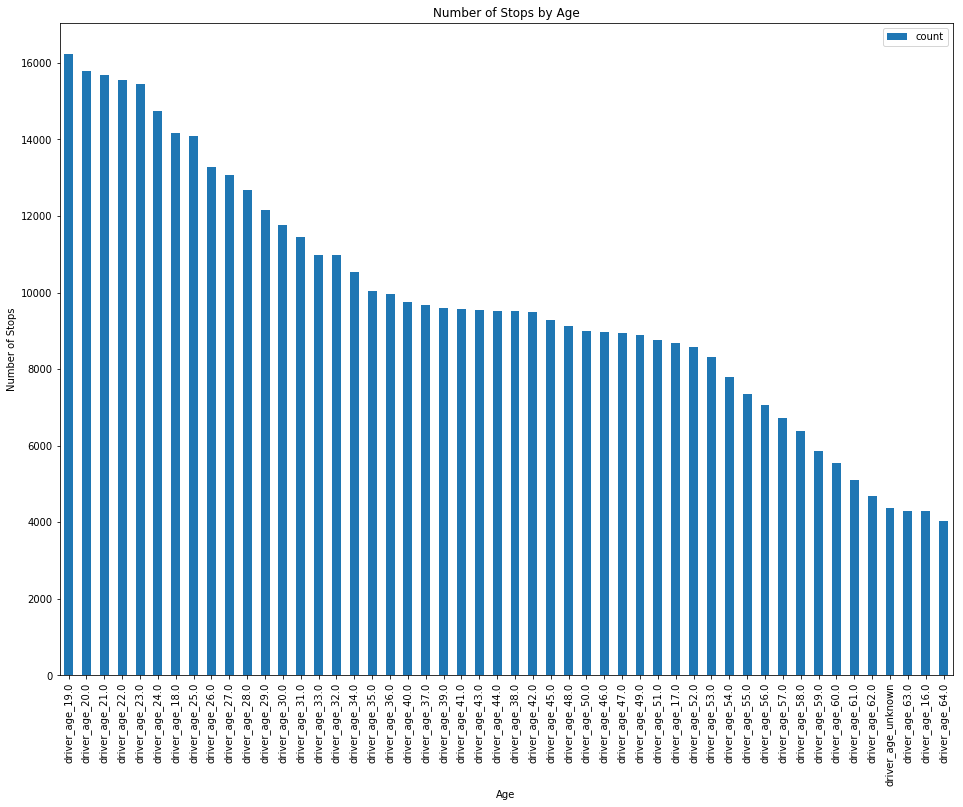

In [62]:
#Show Top 50 Ages of Drivers Pulled Over
cluster3age.plot.bar(x='driver_age', y='count')
plt.xlabel('Age')
plt.ylabel('Number of Stops')
plt.title('Number of Stops by Age')

# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [16.0, 12.0]
print "Current size:", fig_size

# Set figure width to 16 and height to 12
fig_size[0] = 16
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

plt.show()

In [63]:
# Count stops by gender of driver
cluster3gender = cluster3['gender'].value_counts().sort_values(ascending=False)
cluster3gender = cluster3gender.to_frame()
cluster3gender.columns = ['count']
cluster3gender['driver_gender'] = cluster3gender.index
cluster3gender['percent'] = cluster3gender['count']/(cluster3['gender'].notnull().sum())
cluster3gender.head()

,count,driver_gender,percent
driver_gender_F,513970,driver_gender_F,0.999998
driver_gender_unknown,1,driver_gender_unknown,0.000002


In [64]:
# Count stops by race of driver
cluster3race = cluster3['race'].value_counts().sort_values(ascending=False)
cluster3race = cluster3race.to_frame()
cluster3race.columns = ['count']
cluster3race['driver_race'] = cluster3race.index
cluster3race['percent'] = cluster3race['count']/(cluster3['race'].notnull().sum())
cluster3race.head()

,count,driver_race,percent
driver_race_White,429535,driver_race_White,0.835718
driver_race_Hispanic,53790,driver_race_Hispanic,0.104656
driver_race_Black,13209,driver_race_Black,0.025700
driver_race_Asian,8336,driver_race_Asian,0.016219
driver_race_unknown,7648,driver_race_unknown,0.014880


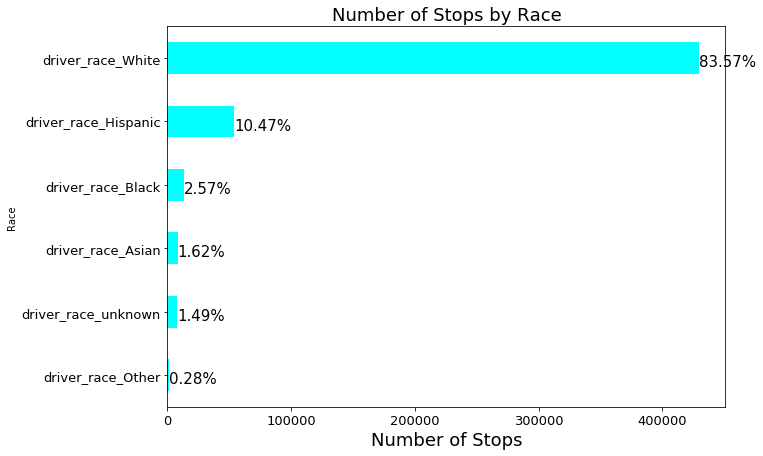

In [65]:
#Show Race of Drivers Pulled Over
ax = cluster3['race'].value_counts().plot(kind='barh', figsize=(10,7),
                                        color='aqua', fontsize=13);
ax.set_alpha(0.8)
ax.set_title('Number of Stops by Race', fontsize=18)
ax.set_xlabel('Number of Stops', fontsize=18)
ax.set_ylabel('Race')

# Add percentages to each bar
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='black')
    
# invert for largest on top 
ax.invert_yaxis()

plt.show()

In [66]:
# Count stops by county of driver
cluster3county = cluster3['county'].value_counts().sort_values(ascending=False)
cluster3county = cluster3county.to_frame()
cluster3county.columns = ['count']
cluster3county['county_name'] = cluster3county.index
cluster3county['percent'] = cluster3county['count']/(cluster3['county'].notnull().sum())
cluster3county.head()

,count,county_name,percent
county_name_El Paso County,43492,county_name_El Paso County,0.084620
county_name_Jefferson County,37903,county_name_Jefferson County,0.073745
county_name_Adams County,29060,county_name_Adams County,0.056540
county_name_Mesa County,27386,county_name_Mesa County,0.053283
county_name_Larimer County,22605,county_name_Larimer County,0.043981


In [67]:
# Count stops by driver violation
cluster3violation = cluster3['violation'].value_counts().sort_values(ascending=False).head()
cluster3violation = cluster3violation.to_frame()
cluster3violation.columns = ['count']
cluster3violation['violation'] = cluster3violation.index
cluster3violation['percent'] = cluster3violation['count']/(cluster3['violation'].notnull().sum())
cluster3violation.head()

,count,violation,percent
violation_Speeding,256898,violation_Speeding,0.499830
violation_Safe movement,96225,violation_Safe movement,0.187219
violation_Lights,49325,violation_Lights,0.095968
violation_Registration/plates,39511,violation_Registration/plates,0.076874
violation_Other,17187,violation_Other,0.033440


In [68]:
# Count stops for In or Out of State 
cluster3state = cluster3['out_of_state'].value_counts().sort_values(ascending=False)
cluster3state = cluster3state.to_frame()
cluster3state.columns = ['count']
cluster3state['out_of_state'] = cluster3state.index
cluster3state['percent'] = cluster3state['count']/(cluster3['out_of_state'].notnull().sum())
cluster3state.head()

,count,out_of_state,percent
out_of_state_False,441973,out_of_state_False,0.859918
out_of_state_True,71850,out_of_state_True,0.139794
out_of_state_unknown,148,out_of_state_unknown,0.000288


## Cluster4

In [69]:
# Count stops by age of driver
cluster4age = cluster4['age'].value_counts().sort_values(ascending=False).head(50)
cluster4age = cluster4age.to_frame()
cluster4age.columns = ['count']
cluster4age['driver_age'] = cluster4age.index
cluster4age['percent'] = cluster4age['count']/(cluster4['age'].notnull().sum())
cluster4age.head(12)

,count,driver_age,percent
driver_age_23.0,6590,driver_age_23.0,0.028326
driver_age_22.0,6545,driver_age_22.0,0.028132
driver_age_24.0,6543,driver_age_24.0,0.028124
driver_age_25.0,6330,driver_age_25.0,0.027208
driver_age_26.0,6113,driver_age_26.0,0.026275
driver_age_21.0,5969,driver_age_21.0,0.025656
driver_age_27.0,5781,driver_age_27.0,0.024848
driver_age_28.0,5636,driver_age_28.0,0.024225
driver_age_29.0,5430,driver_age_29.0,0.023340
driver_age_30.0,5274,driver_age_30.0,0.022669


Current size: [16.0, 12.0]


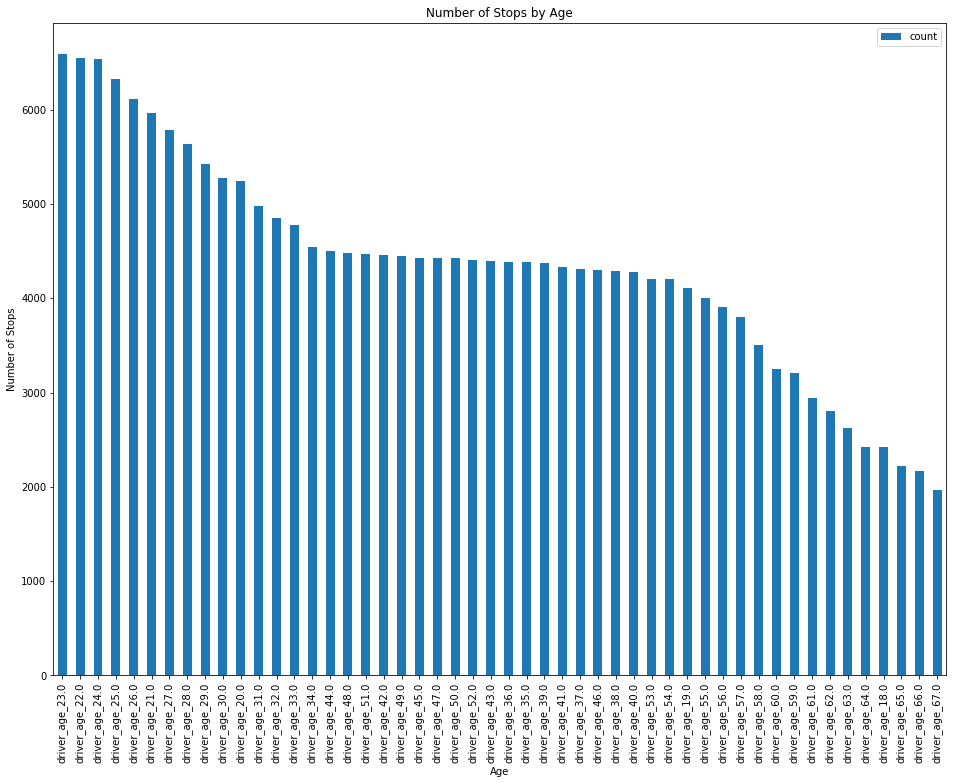

In [70]:
#Show Top 50 Ages of Drivers Pulled Over
cluster4age.plot.bar(x='driver_age', y='count')
plt.xlabel('Age')
plt.ylabel('Number of Stops')
plt.title('Number of Stops by Age')

# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [16.0, 12.0]
print "Current size:", fig_size

# Set figure width to 16 and height to 12
fig_size[0] = 16
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

plt.show()

In [71]:
# Count stops by gender of driver
cluster4gender = cluster4['gender'].value_counts().sort_values(ascending=False)
cluster4gender = cluster4gender.to_frame()
cluster4gender.columns = ['count']
cluster4gender['driver_gender'] = cluster4gender.index
cluster4gender['percent'] = cluster4gender['count']/(cluster4['gender'].notnull().sum())
cluster4gender.head()

,count,driver_gender,percent
driver_gender_M,232086,driver_gender_M,0.997567
driver_gender_unknown,566,driver_gender_unknown,0.002433


In [72]:
# Count stops by race of driver
cluster4race = cluster4['race'].value_counts().sort_values(ascending=False)
cluster4race = cluster4race.to_frame()
cluster4race.columns = ['count']
cluster4race['driver_race'] = cluster4race.index
cluster4race['percent'] = cluster4race['count']/(cluster4['race'].notnull().sum())
cluster4race.head()

,count,driver_race,percent
driver_race_White,183834,driver_race_White,0.790167
driver_race_Hispanic,26722,driver_race_Hispanic,0.114858
driver_race_Black,11009,driver_race_Black,0.047320
driver_race_unknown,5568,driver_race_unknown,0.023933
driver_race_Asian,4149,driver_race_Asian,0.017834


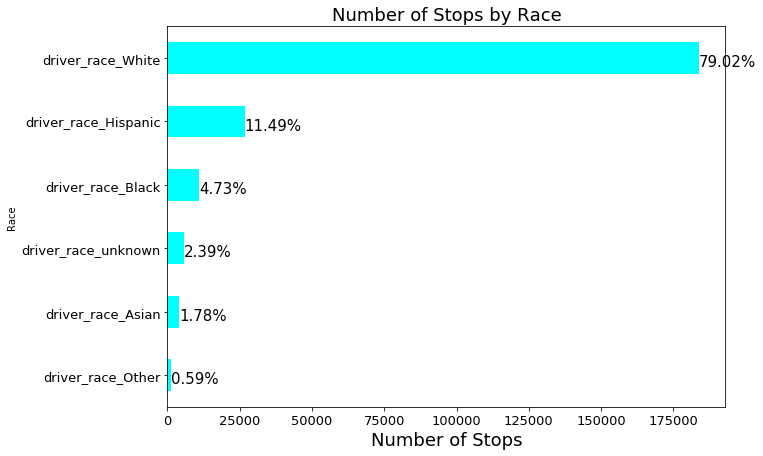

In [73]:
#Show Race of Drivers Pulled Over
ax = cluster4['race'].value_counts().plot(kind='barh', figsize=(10,7),
                                        color='aqua', fontsize=13);
ax.set_alpha(0.8)
ax.set_title('Number of Stops by Race', fontsize=18)
ax.set_xlabel('Number of Stops', fontsize=18)
ax.set_ylabel('Race')

# Add percentages to each bar
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='black')
    
# invert for largest on top 
ax.invert_yaxis()

plt.show()

In [74]:
# Count stops by county of driver
cluster4county = cluster4['county'].value_counts().sort_values(ascending=False)
cluster4county = cluster4county.to_frame()
cluster4county.columns = ['count']
cluster4county['county_name'] = cluster4county.index
cluster4county['percent'] = cluster4county['count']/(cluster4['county'].notnull().sum())
cluster4county.head()

,count,county_name,percent
county_name_El Paso County,11284,county_name_El Paso County,0.048502
county_name_Mesa County,10745,county_name_Mesa County,0.046185
county_name_Logan County,10315,county_name_Logan County,0.044337
county_name_Las Animas County,9428,county_name_Las Animas County,0.040524
county_name_Larimer County,8715,county_name_Larimer County,0.037459


In [75]:
# Count stops by driver violation
cluster4violation = cluster4['violation'].value_counts().sort_values(ascending=False).head()
cluster4violation = cluster4violation.to_frame()
cluster4violation.columns = ['count']
cluster4violation['violation'] = cluster4violation.index
cluster4violation['percent'] = cluster4violation['count']/(cluster4['violation'].notnull().sum())
cluster4violation.head()

,count,violation,percent
violation_Speeding,130201,violation_Speeding,0.559638
violation_Safe movement,37410,violation_Safe movement,0.160798
violation_Truck,15198,violation_Truck,0.065325
violation_Lights,14811,violation_Lights,0.063662
violation_Other (non-mapped),11841,violation_Other (non-mapped),0.050896


In [76]:
# Count stops for In or Out of State 
cluster4state = cluster4['out_of_state'].value_counts().sort_values(ascending=False)
cluster4state = cluster4state.to_frame()
cluster4state.columns = ['count']
cluster4state['out_of_state'] = cluster4state.index
cluster4state['percent'] = cluster4state['count']/(cluster4['out_of_state'].notnull().sum())
cluster4state.head()

,count,out_of_state,percent
out_of_state_True,232652,out_of_state_True,1.0
